In [1]:
# Cell 1: Imports and basic configuration
import itertools
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import ipywidgets as widgets

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)


In [2]:
# Cell 2: Define Mastermind parameters and candidate generation
NUM_POSITIONS = 4
COLORS = ['R', 'G', 'B', 'Y', 'O', 'P']  # 6 colors

# Generate all possible codes (each code is a tuple of characters)
def generate_all_codes():
    return list(itertools.product(COLORS, repeat=NUM_POSITIONS))

all_codes = generate_all_codes()
print("Total candidate codes:", len(all_codes))


Total candidate codes: 46656


In [3]:
# Cell 3: Define feedback function
def get_feedback(secret, guess):
    """
    Returns a tuple (black, white):
    - black: correct color in correct position
    - white: correct color in wrong position
    """
    black = sum(s == g for s, g in zip(secret, guess))
    # Count colors in secret and guess
    secret_color_count = {color: secret.count(color) for color in COLORS}
    guess_color_count = {color: guess.count(color) for color in COLORS}
    # Total common elements minus blacks gives white pegs
    common = sum(min(secret_color_count.get(color,0), guess_color_count.get(color,0)) for color in COLORS)
    white = common - black
    return black, white

# Quick test of feedback function
test_secret = ('R', 'G', 'B', 'Y')
test_guess  = ('R', 'B', 'Y', 'O')
print("Feedback:", get_feedback(test_secret, test_guess))


Feedback: (1, 2)


In [4]:
# Cell 4: Define function to filter candidate codes based on guess and feedback
def filter_candidates(candidates, guess, feedback):
    filtered = []
    for code in candidates:
        if get_feedback(code, guess) == feedback:
            filtered.append(code)
    return filtered

# Test filtering function with a sample guess and feedback
sample_guess = ('R', 'G', 'B', 'Y')
sample_feedback = (2, 1)  # Example: 2 black, 1 white
filtered_codes = filter_candidates(all_codes, sample_guess, sample_feedback)
print("Candidates remaining after filtering:", len(filtered_codes))


Candidates remaining after filtering: 2928


In [5]:
# Cell 5: Heuristic to select next guess
def select_next_guess(candidates):
    """
    A simple heuristic: choose the candidate that minimizes the maximum 
    remaining candidate count over all possible feedbacks.
    """
    best_guess = None
    best_score = float('inf')
    
    for guess in candidates:
        feedback_counts = {}
        for secret in candidates:
            fb = get_feedback(secret, guess)
            feedback_counts[fb] = feedback_counts.get(fb, 0) + 1
        worst_case = max(feedback_counts.values())
        if worst_case < best_score:
            best_score = worst_case
            best_guess = guess
    return best_guess

# For speed, if candidate set is large, one might sample a subset.


In [6]:
# Cell 6: Main solver function that simulates a game
def mastermind_solver(secret_code):
    candidates = generate_all_codes()
    history = []  # list of tuples: (guess, feedback, remaining candidates count)
    
    # Initial guess: you may choose a fixed guess
    guess = [COLORS[i%len(COLORS)] for i in range(NUM_POSITIONS)]
    iteration = 0
    
    while True:
        iteration += 1
        fb = get_feedback(secret_code, guess)
        history.append((guess, fb, len(candidates)))
        if fb[0] == NUM_POSITIONS:
            break
        candidates = filter_candidates(candidates, guess, fb)
        # For performance, if candidates set is small, use all; else, sample if needed.
        if len(candidates) == 0:
            print("No candidates left!")
            break
        guess = select_next_guess(candidates)
    return history

# Simulate a game with a random secret code
secret = random.choice(all_codes)
print("Secret Code:", secret)
history = mastermind_solver(secret)
print("Solved in", len(history), "iterations")


Secret Code: ('P', 'B', 'B', 'R', 'R', 'G')
Solved in 7 iterations


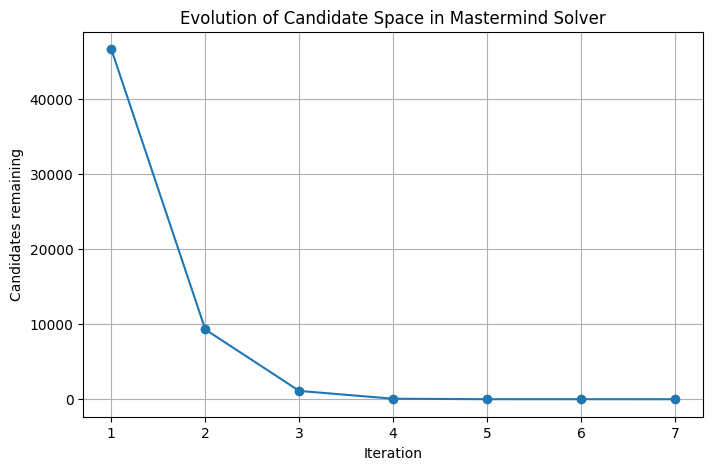

In [7]:
# Cell 7: Visualization of candidate space evolution over iterations
def plot_history(history):
    iterations = list(range(1, len(history)+1))
    candidates_remaining = [entry[2] for entry in history]
    
    plt.figure(figsize=(8,5))
    plt.plot(iterations, candidates_remaining, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Candidates remaining')
    plt.title('Evolution of Candidate Space in Mastermind Solver')
    plt.grid(True)
    plt.show()

plot_history(history)


In [8]:
# Cell 8: Interactive widget for simulating a game with user input for feedback
def interactive_mastermind(secret_code=None):
    if secret_code is None:
        secret_code = random.choice(all_codes)
    candidates = generate_all_codes()
    iteration = 0
    history = []
    
    guess = [COLORS[i%len(COLORS)] for i in range(NUM_POSITIONS)]
    out = widgets.Output()
    
    def on_button_click(b):
        nonlocal candidates, guess, iteration, history
        # Read user input feedback
        try:
            black = int(black_widget.value)
            white = int(white_widget.value)
        except:
            with out:
                print("Invalid input, please enter integers for feedback.")
            return
        fb = (black, white)
        history.append((guess, fb, len(candidates)))
        with out:
            print(f"Iteration {iteration+1}: Guess {guess}, Feedback {fb}, Candidates left: {len(candidates)}")
        if fb[0] == NUM_POSITIONS:
            with out:
                print("Solver found the secret code!")
            return
        candidates = filter_candidates(candidates, guess, fb)
        if len(candidates) == 0:
            with out:
                print("No candidates left. Check your feedback!")
            return
        guess = select_next_guess(candidates)
        iteration += 1
        guess_label.value = f"Next Guess: {guess}"
    
    black_widget = widgets.Text(value='', placeholder='Enter black pegs', description='Black:')
    white_widget = widgets.Text(value='', placeholder='Enter white pegs', description='White:')
    submit_button = widgets.Button(description="Submit Feedback")
    submit_button.on_click(on_button_click)
    guess_label = widgets.Label(value=f"Next Guess: {guess}")
    
    ui = widgets.VBox([guess_label, black_widget, white_widget, submit_button, out])
    display(ui)

# Launch the interactive simulation (feedback must be entered manually)
interactive_mastermind()


In [ ]:
# Cell 9: Running multiple simulations and plotting statistics
def run_simulations(num_simulations=50):
    iterations_list = []
    for _ in range(num_simulations):
        secret = random.choice(all_codes)
        hist = mastermind_solver(secret)
        iterations_list.append(len(hist))
    return iterations_list

sim_results = run_simulations(50)
print("Average iterations:", np.mean(sim_results))
plt.figure(figsize=(8,5))
plt.hist(sim_results, bins=range(min(sim_results), max(sim_results)+2), edgecolor='black', align='left')
plt.xlabel('Iterations to solve')
plt.ylabel('Frequency')
plt.title('Histogram of iterations over multiple simulations')
plt.show()


In [24]:
# Cell 10: Final demonstration and execution block
def main():
    # Run a single simulation and display the history and plot
    secret = random.choice(all_codes)
    print("Secret Code (hidden in real game):", secret)
    hist = mastermind_solver(secret)
    print("Solution history (guess, feedback, candidates count):")
    for i, entry in enumerate(hist, 1):
        print(f"Iteration {i}: {entry}")
    plot_history(hist)
    
    # Run interactive widget demo (if desired)
    print("\nLaunching interactive simulation widget:")
    interactive_mastermind(secret)

# Execute main function
if __name__ == "__main__":
    main()


Secret Code (hidden in real game): ('G', 'P', 'Y', 'R', 'P', 'G')


KeyboardInterrupt: 